In [59]:
# Cell 1 — Imports and notebook / plotting settings
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Notebook display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (11, 6)
sns.set(style="whitegrid")
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 200)


In [60]:
# Cell 2 — Robust file loader (tries provided path, fallbacks, and multiple encodings)
import os
import glob
import pandas as pd

# Replace this with your path if different
CANDIDATE_PATH = "/content/sample_data/Netflix Dataset .csv"

def try_read_csv(path):
    """Try to read CSV with a few encodings. Returns dataframe or raises last exception."""
    last_exc = None
    for enc in (None, "utf-8", "latin1", "cp1252"):
        try:
            if enc is None:
                df_local = pd.read_csv(path)
            else:
                df_local = pd.read_csv(path, encoding=enc)
            print(f"Loaded: {path!r} (encoding={enc or 'default'}) — shape={df_local.shape}")
            return df_local
        except Exception as e:
            last_exc = e
    raise last_exc

print("Checking /content/sample_data folder (first 200 entries):")
try:
    print(os.listdir("/content/sample_data")[:200])
except Exception as e:
    print("Could not list /content/sample_data:", e)

# look for any csv under /content or /content/sample_data containing 'netflix' (case-insensitive)
candidates = [p for p in glob.glob("/content/**/*.csv", recursive=True) if 'netflix' in os.path.basename(p).lower()]
candidates_sample = [p for p in glob.glob("/content/sample_data/*.csv") if 'netflix' in os.path.basename(p).lower()]
print("\nDetected netflix-related candidates (global):", candidates[:10])
print("Detected netflix-related candidates (sample_data):", candidates_sample[:10])

# Try the exact path first, then normalized variants, then discovered candidates
path_to_try = None
if os.path.exists(CANDIDATE_PATH):
    path_to_try = CANDIDATE_PATH
else:
    # try trim double spaces and ' .csv' -> '.csv'
    alt = CANDIDATE_PATH.replace("  ", " ").replace(" .csv", ".csv")
    if os.path.exists(alt):
        print(f"Found alternate path by trimming: {alt!r}")
        path_to_try = alt
    elif candidates_sample:
        path_to_try = candidates_sample[0]
        print(f"No exact file at candidate path. Using detected sample_data candidate: {path_to_try!r}")
    elif candidates:
        path_to_try = candidates[0]
        print(f"No exact file at candidate path. Using detected candidate: {path_to_try!r}")
    else:
        # last attempt: list /content directory
        print("No netflix CSV found under /content by name. Listing top-level /content files for debugging:")
        print(os.listdir("/content")[:200])
        raise FileNotFoundError(
            f"Could not find the file at {CANDIDATE_PATH!r} or any netflix-related CSV under /content/. "
            "Please upload the CSV to Colab (Files panel) or provide the exact path."
        )

# Finally load
df = try_read_csv(path_to_try)

# Quick diagnostics
print("\nColumns loaded:", df.columns.tolist())
display(df.head(3))


Checking /content/sample_data folder (first 200 entries):
['anscombe.json', 'README.md', 'Netflix Dataset .csv', 'california_housing_train.csv', 'mnist_train_small.csv', 'mnist_test.csv', 'california_housing_test.csv']

Detected netflix-related candidates (global): ['/content/sample_data/Netflix Dataset .csv']
Detected netflix-related candidates (sample_data): ['/content/sample_data/Netflix Dataset .csv']
Loaded: '/content/sample_data/Netflix Dataset .csv' (encoding=default) — shape=(7789, 11)

Columns loaded: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."


In [61]:
# Cell 3 — Standardize column names and detect key columns
# Make a non-destructive mapping for common column names
orig_columns = df.columns.tolist()
print("Original columns:", orig_columns)

# Create a case-insensitive map
col_map = {}
for col in orig_columns:
    k = col.strip().lower().replace(" ", "_")
    col_map[k] = col  # map normalized key -> original column name

# Utility to find closest column by common names
def find_col(*names):
    """Return actual column name for the first matching candidate in names, or None."""
    for name in names:
        key = name.lower().replace(" ", "_")
        if key in col_map:
            return col_map[key]
    return None

# Detect commonly used columns (many Netflix datasets use these names)
title_col = find_col("title")
type_col = find_col("type", "show_type")
date_added_col = find_col("date_added")
release_year_col = find_col("release_year", "year")
country_col = find_col("country", "countries")
genre_col = find_col("listed_in", "genres")
duration_col = find_col("duration")
description_col = find_col("description", "summary")
director_col = find_col("director")
cast_col = find_col("cast")

print("\nDetected columns mapping (if None, column not found):")
print(f" title: {title_col}")
print(f" type: {type_col}")
print(f" date_added: {date_added_col}")
print(f" release_year: {release_year_col}")
print(f" country: {country_col}")
print(f" genres/listed_in: {genre_col}")
print(f" duration: {duration_col}")
print(f" description: {description_col}")
print(f" director: {director_col}")
print(f" cast: {cast_col}")

# If title not found, create one (should not happen)
if title_col is None:
    df['title'] = df.iloc[:,0].astype(str)
    title_col = 'title'
    print("No title column detected — using first column as 'title'.")


Original columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']

Detected columns mapping (if None, column not found):
 title: Title
 type: Type
 date_added: None
 release_year: None
 country: Country
 genres/listed_in: None
 duration: Duration
 description: Description
 director: Director
 cast: Cast


In [62]:
# Cell 4 — Basic cleaning & derived columns (safe handling)
import numpy as np
# Ensure title is string and trimmed
df[title_col] = df[title_col].astype(str).str.strip()

# Normalize 'type' values (if exists)
if type_col and type_col in df.columns:
    df[type_col] = df[type_col].astype(str).str.strip().replace({'nan': np.nan})
else:
    df['type'] = np.nan
    type_col = 'type'

# Parse 'date_added' if present
if date_added_col and date_added_col in df.columns:
    df['date_added_parsed'] = pd.to_datetime(df[date_added_col], errors='coerce')
else:
    df['date_added_parsed'] = pd.NaT

# Clean release year
if release_year_col and release_year_col in df.columns:
    df['release_year_clean'] = pd.to_numeric(df[release_year_col], errors='coerce').astype('Int64')
else:
    df['release_year_clean'] = pd.NA

# Parse duration into numeric and unit
def parse_duration(v):
    if pd.isna(v):
        return (np.nan, None)
    s = str(v).strip()
    s_low = s.lower()
    # e.g., "90 min", "1 Season", "2 Seasons"
    if 'min' in s_low:
        digits = ''.join(ch for ch in s if ch.isdigit())
        try:
            return (int(digits), 'minutes')
        except:
            return (np.nan, 'minutes')
    if 'season' in s_low:
        digits = ''.join(ch for ch in s if ch.isdigit())
        try:
            return (int(digits), 'seasons')
        except:
            return (np.nan, 'seasons')
    # fallback numeric
    try:
        return (int(s), None)
    except:
        return (np.nan, None)

df[['duration_parsed', 'duration_unit']] = df[duration_col].apply(lambda x: pd.Series(parse_duration(x))) if duration_col else pd.DataFrame({'duration_parsed': np.nan, 'duration_unit': None})


In [63]:
# Cell 5 — Explode multi-valued genres and countries for easier aggregation
# genres/listed_in
if genre_col and genre_col in df.columns:
    df[genre_col] = df[genre_col].fillna('Unknown').astype(str)
    df_expl = df.assign(genre = df[genre_col].str.split(',')).explode('genre')
    df_expl['genre'] = df_expl['genre'].str.strip().replace({'': 'Unknown'})
else:
    df_expl = df.copy()
    df_expl['genre'] = 'Unknown'

# countries
if country_col and country_col in df_expl.columns:
    df_expl[country_col] = df_expl[country_col].fillna('Unknown').astype(str)
    df_expl = df_expl.assign(country_exploded = df_expl[country_col].str.split(',')).explode('country_exploded')
    df_expl['country_exploded'] = df_expl['country_exploded'].str.strip().replace({'': 'Unknown'})
else:
    df_expl['country_exploded'] = 'Unknown'

# Choose the year to use for time series (prefer date_added year, else release_year)
df_expl['year_for_time'] = df_expl['date_added_parsed'].dt.year.fillna(df_expl['release_year_clean'])
# Drop rows missing title
df_expl = df_expl[df_expl[title_col].notna()].copy()


In [64]:
# Cell 6 — Sanity checks and quick counts
print("Rows in original df:", df.shape)
print("Rows after explode (genres/countries):", df_expl.shape)
print("\nUnique titles:", df_expl[title_col].nunique())
print("\nTop 10 genres:")
display(df_expl['genre'].value_counts().nlargest(10))
print("\nTop 10 countries:")
display(df_expl['country_exploded'].value_counts().nlargest(10))
print("\nSample types present:")
display(df_expl[type_col].value_counts().head(10))


Rows in original df: (7789, 15)
Rows after explode (genres/countries): (9576, 18)

Unique titles: 7786

Top 10 genres:


,count
genre,
Unknown,9576



Top 10 countries:


,count
country_exploded,
United States,3298
India,990
United Kingdom,723
Unknown,511
Canada,412
France,349
Japan,287
Spain,215
South Korea,212



Sample types present:


,count
Type,
"Dramas, International Movies",434
Documentaries,396
Stand-Up Comedy,322
"Dramas, Independent Movies, International Movies",320
"Documentaries, International Movies",291
Kids' TV,287
"Comedies, Dramas, International Movies",280
"Children & Family Movies, Comedies",251
Children & Family Movies,218


/tmp/ipython-input-4271293219.py:19: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



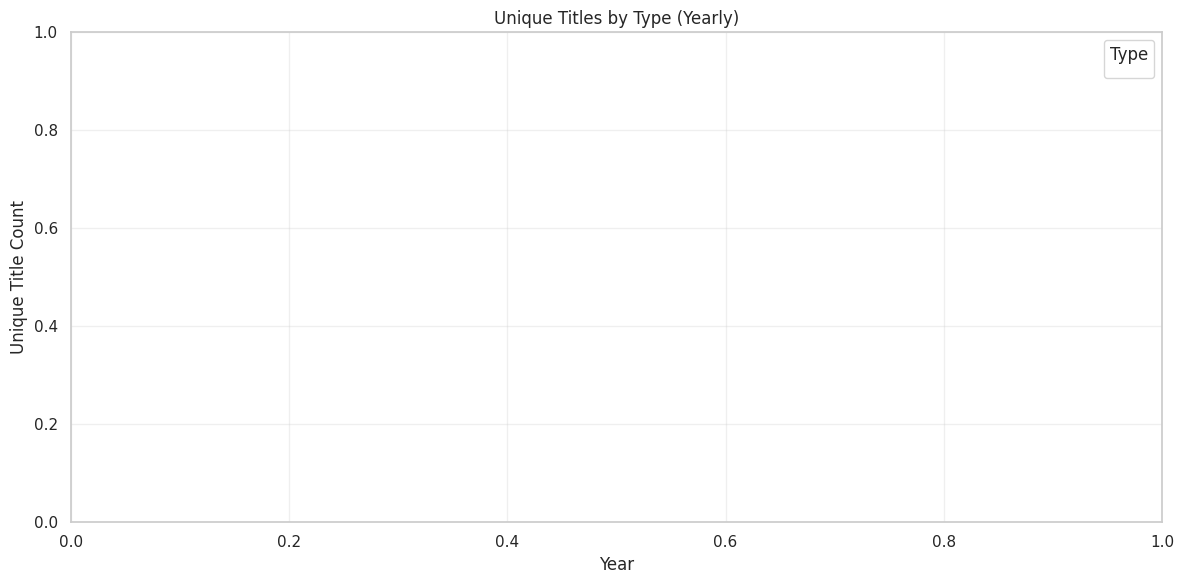

In [65]:
# Cell 7 — Visualization: Movies vs TV Shows over years (matplotlib)
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12,6)

# Ensure year_for_time numeric and drop NaNs
df_time = df_expl.dropna(subset=['year_for_time']).copy()
df_time['year_for_time'] = df_time['year_for_time'].astype(int)

time_counts = df_time.groupby(['year_for_time', type_col])[title_col].nunique().reset_index().rename(columns={title_col:'unique_count'})
pivot_time = time_counts.pivot(index='year_for_time', columns=type_col, values='unique_count').fillna(0)

plt.figure()
for col in pivot_time.columns:
    plt.plot(pivot_time.index, pivot_time[col], marker='o', label=str(col))
plt.title('Unique Titles by Type (Yearly)')
plt.xlabel('Year')
plt.ylabel('Unique Title Count')
plt.legend(title='Type')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


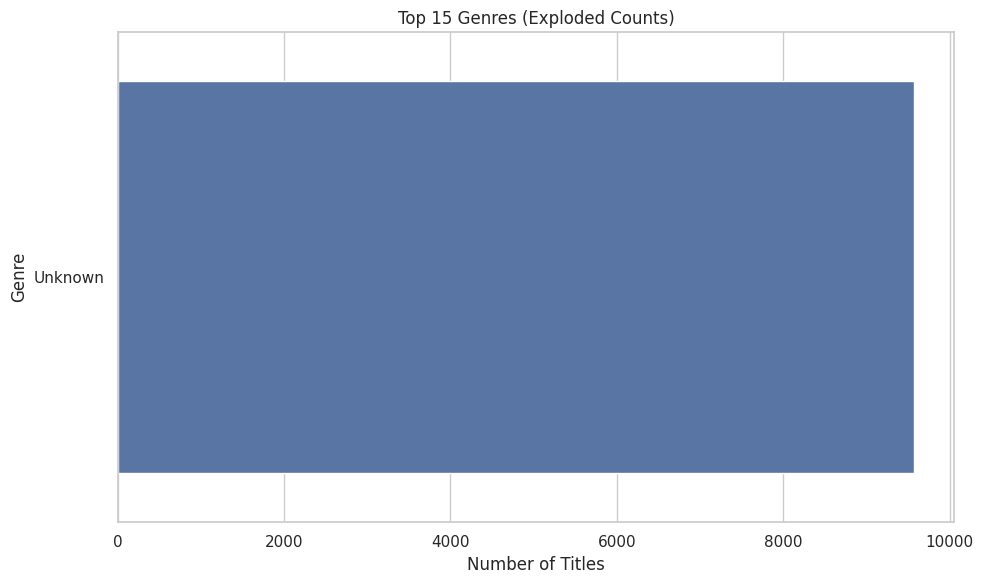

In [66]:
# Cell 8 — Visualization: Top 15 Genres (horizontal bar)
top_genres = df_expl['genre'].value_counts().nlargest(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title('Top 15 Genres (Exploded Counts)')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


In [67]:
# Cell 9 — Visualization: Top N genre trends over time (Plotly interactive)
import plotly.express as px
topN = 8
top_genre_list = df_expl['genre'].value_counts().nlargest(topN).index.tolist()
genre_time = df_expl[df_expl['genre'].isin(top_genre_list)].groupby(['year_for_time','genre'])[title_col].nunique().reset_index().rename(columns={title_col:'count'})
fig = px.line(genre_time, x='year_for_time', y='count', color='genre', markers=True, title=f'Yearly trends for top {topN} genres')
fig.update_layout(xaxis_title='Year', yaxis_title='Unique title count')
fig.show()


In [68]:
# Fixed Cell 10 — Robust Country contributions (choropleth)
import plotly.express as px

# Inspect available columns to decide what to use
print("Columns available in df_expl (sample):", df_expl.columns.tolist())

# Prefer an already-exploded column if it exists
if 'country_exploded' in df_expl.columns:
    country_col_to_use = 'country_exploded'
else:
    # fallback: try common names
    possible = [c for c in df_expl.columns if 'country' in c.lower() or 'countries' in c.lower()]
    country_col_to_use = possible[0] if possible else None

if country_col_to_use is None:
    # nothing found — show top-level few unique columns and raise helpful error
    print("No country-like column detected. Here are some column name samples to help debug:")
    print(df_expl.columns.tolist()[:40])
    raise KeyError("No country-like column found in df_expl. Inspect column names above.")

print(f"Using country column: {country_col_to_use!r}")

# Prepare counts — be defensive about null/Unknown
country_series = df_expl[country_col_to_use].fillna('Unknown').astype(str)
# If values include commas (not exploded), attempt to explode them now
if country_series.str.contains(',').any() and country_col_to_use != 'country_exploded':
    # explode on comma
    tmp = df_expl.assign(_tmp_country = df_expl[country_col_to_use].fillna('Unknown').astype(str).str.split(',')).explode('_tmp_country')
    tmp['_tmp_country'] = tmp['_tmp_country'].str.strip()
    country_counts = tmp['_tmp_country'].value_counts().reset_index()
    country_counts.columns = ['country', 'count']
else:
    country_counts = country_series.value_counts().reset_index()
    country_counts.columns = ['country', 'count']

# Remove Unknown/empty entries for the map
country_counts = country_counts[country_counts['country'].notna() & (country_counts['country'].str.strip().str.lower() != 'unknown') & (country_counts['country'].str.strip() != '')]

# Quick check of top countries
print("Top countries (sample):")
display(country_counts.head(12))

# If country names look like multi-values joined or weird forms, print examples for manual mapping
weird = country_counts[country_counts['country'].str.contains(';|\\||/|\\\\') | country_counts['country'].str.contains(',')]
if not weird.empty:
    print("Some country names contain separators or multiple values (showing examples):")
    display(weird.head(10))

# Now draw the choropleth (Plotly). Plotly expects pretty standard country names.
try:
    fig = px.choropleth(country_counts, locations='country', locationmode='country names',
                        color='count', hover_name='country', title='Number of Titles by Country')
    fig.update_layout(coloraxis_colorbar=dict(title='Title Count'))
    fig.show()
except Exception as e:
    print("Plotly choropleth failed (likely due to non-standard country names). Example country name samples:")
    print(country_counts['country'].head(20).tolist())
    raise


Columns available in df_expl (sample): ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description', 'date_added_parsed', 'release_year_clean', 'duration_parsed', 'duration_unit', 'genre', 'country_exploded', 'year_for_time']
Using country column: 'country_exploded'
Top countries (sample):


,country,count
0,United States,3298
1,India,990
2,United Kingdom,723
4,Canada,412
5,France,349
6,Japan,287
7,Spain,215
8,South Korea,212
9,Germany,199
10,Mexico,154


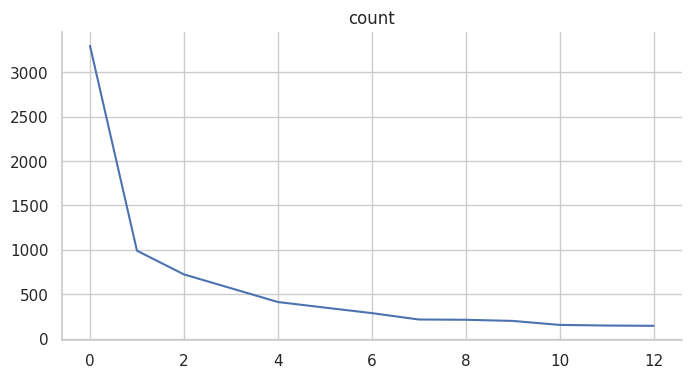

In [69]:
from matplotlib import pyplot as plt
_df_1['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

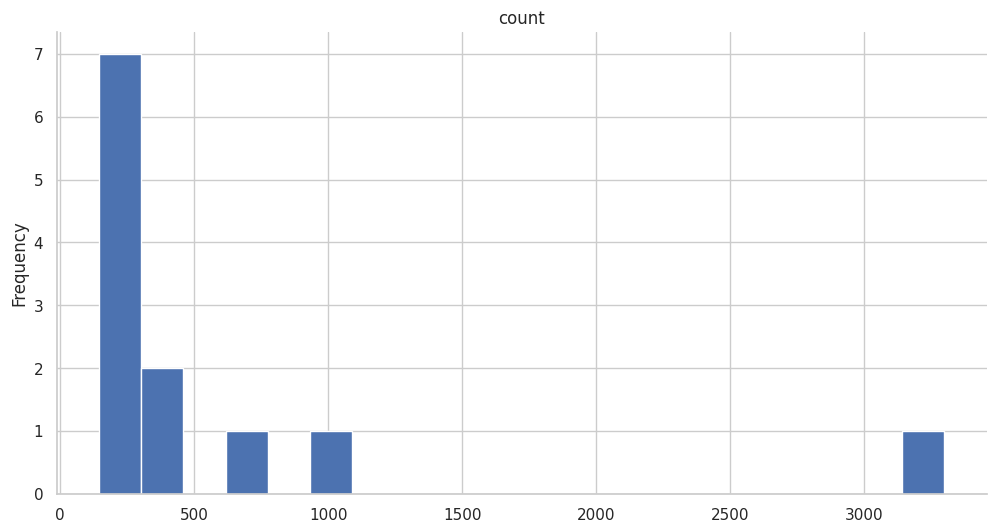

In [70]:
from matplotlib import pyplot as plt
_df_0['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

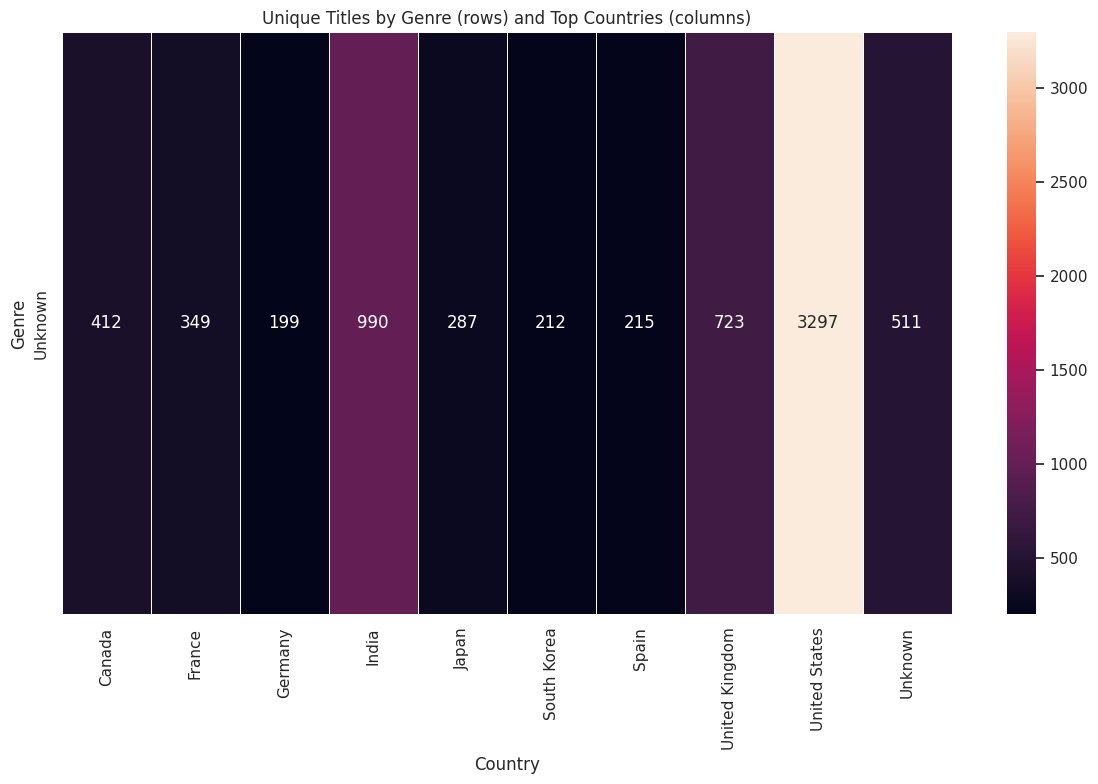

In [71]:
# Cell 11 — Visualization: Heatmap Genre x Top Countries
top_countries = df_expl['country_exploded'].value_counts().nlargest(10).index.tolist()
top_genres_small = df_expl['genre'].value_counts().nlargest(10).index.tolist()

heat_df = df_expl[df_expl['country_exploded'].isin(top_countries) & df_expl['genre'].isin(top_genres_small)]
pivot = heat_df.groupby(['genre','country_exploded'])[title_col].nunique().unstack(fill_value=0)

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt='d', linewidths=.5)
plt.title('Unique Titles by Genre (rows) and Top Countries (columns)')
plt.xlabel('Country')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


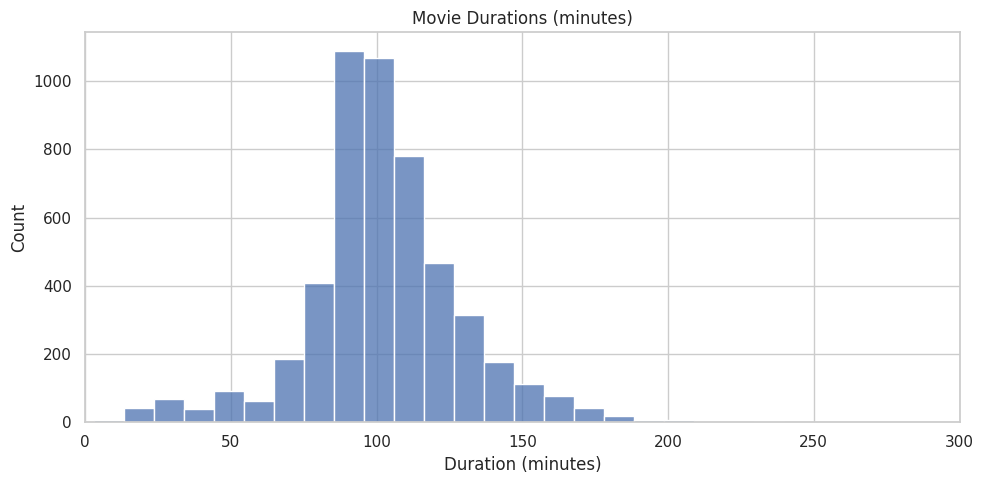

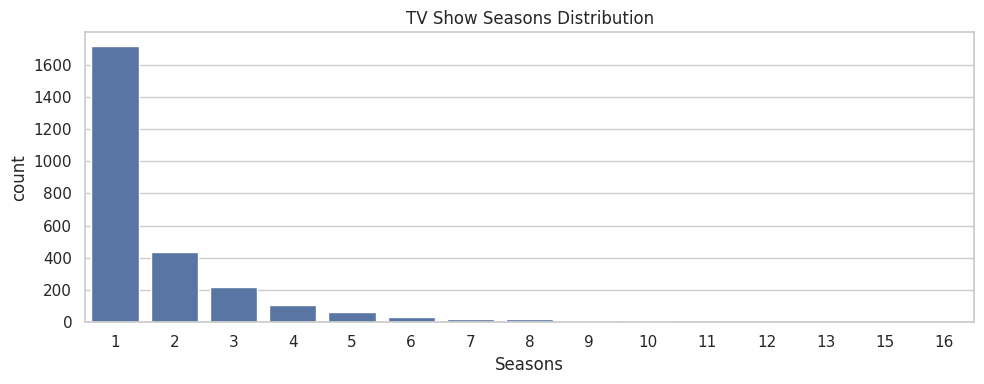

In [72]:
# Cell 12 — Visualization: Duration distributions (movies minutes vs tv seasons)
# Movie durations (minutes)
movies_minutes = df_expl[(df_expl[type_col].astype(str).str.lower().str.contains('movie')) & (df_expl['duration_unit']=='minutes')]
plt.figure(figsize=(10,5))
sns.histplot(movies_minutes['duration_parsed'].dropna(), bins=30)
plt.title('Movie Durations (minutes)')
plt.xlabel('Duration (minutes)')
plt.xlim(0, 300)
plt.tight_layout()
plt.show()

# TV seasons distribution
tv_seasons = df_expl[(df_expl[type_col].astype(str).str.lower().str.contains('tv|show')) & (df_expl['duration_unit']=='seasons')]
plt.figure(figsize=(10,4))
sns.countplot(x='duration_parsed', data=tv_seasons, order=sorted(tv_seasons['duration_parsed'].dropna().unique()))
plt.title('TV Show Seasons Distribution')
plt.xlabel('Seasons')
plt.tight_layout()
plt.show()


In [73]:
# Cell 13 — Optional: TF-IDF + KMeans clustering on descriptions (sample up to 2500)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

if description_col and description_col in df_expl.columns:
    desc_df = df_expl[[title_col, description_col]].dropna().drop_duplicates(subset=[title_col])
    sample = desc_df.head(2500).reset_index(drop=True)
    if sample.shape[0] >= 10:
        tf = TfidfVectorizer(max_features=2000, stop_words='english')
        X = tf.fit_transform(sample[description_col])
        k = 6
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        sample['cluster'] = km.fit_predict(X)
        terms = tf.get_feature_names_out()
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]
        print("Top terms per cluster (sample):")
        for i in range(k):
            top_terms = [terms[ind] for ind in order_centroids[i, :10]]
            print(f"Cluster {i}: {top_terms}")
    else:
        print("Not enough descriptions for clustering.")
else:
    print("Description column not found — skipping clustering.")


Top terms per cluster (sample):
Cluster 0: ['young', 'man', 'woman', 'life', 'love', 'boy', 'marriage', 'father', 'girl', 'family']
Cluster 1: ['life', 'new', 'world', 'friends', 'family', 'series', 'love', 'lives', 'special', 'stand']
Cluster 2: ['documentary', 'follows', 'explores', 'life', 'series', 'world', 'intimate', 'examines', 'interviews', 'chronicles']
Cluster 3: ['home', 'finds', 'husband', 'secret', 'dreams', 'new', 'family', 'woman', 'life', 'help']
Cluster 4: ['man', 'son', 'falls', 'father', 'family', 'woman', 'love', 'wife', 'brother', 'help']
Cluster 5: ['school', 'high', 'student', 'students', 'teen', 'new', 'friends', 'girls', 'best', 'team']


In [74]:
# Cell 14 — Save useful plots to disk for PPT insertion
out_dir = "/content/plots_for_ppt"
os.makedirs(out_dir, exist_ok=True)

# Save top genres (recreate)
plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index)
plt.title('Top 15 Genres (Exploded Counts)')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'top_15_genres.png'), dpi=300)
plt.close()

# Save movies vs tv plot
plt.figure(figsize=(12,6))
for col in pivot_time.columns:
    plt.plot(pivot_time.index, pivot_time[col], marker='o', label=str(col))
plt.title('Unique Titles by Type (Yearly)')
plt.xlabel('Year')
plt.ylabel('Unique Title Count')
plt.legend(title='Type')
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'movies_vs_tv_by_year.png'), dpi=300)
plt.close()

print("Saved example plots to:", out_dir)


/tmp/ipython-input-604005112.py:20: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Saved example plots to: /content/plots_for_ppt
